In [5]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import pickle

# ĐỌC DỮ LIỆU

df = pd.read_csv("../../data/metadata.csv")  # đổi tên file nếu khác

# Giữ lại các cột dạng boolean (0/1)
symptom_cols = ['cough', 'fever', 'fatigue', 'shortness_of_breath', 'chest_pain']
disease_cols = ['COVID-19', 'PNEUMONIA', 'NORMAL']

# Chỉ lấy các cột có thể tham gia luật
data = df[symptom_cols + disease_cols].astype(bool)

# SINH LUẬT KẾT HỢP

frequent_itemsets = apriori(data, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Lọc ra luật có ý nghĩa: từ triệu chứng đến bệnh
rules = rules[rules['consequents'].apply(lambda x: any(d in x for d in disease_cols))]
rules = rules[rules['antecedents'].apply(lambda x: any(s in x for s in symptom_cols))]

# Reset index cho gọn
rules = rules.sort_values(by="lift", ascending=False).reset_index(drop=True)

print(" Số luật tìm được:", len(rules))
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())




 Số luật tìm được: 21
                           antecedents                       consequents  \
0         (shortness_of_breath, fever)                       (PNEUMONIA)   
1  (shortness_of_breath, cough, fever)                       (PNEUMONIA)   
2                              (fever)  (shortness_of_breath, PNEUMONIA)   
3                (shortness_of_breath)                (fever, PNEUMONIA)   
4         (shortness_of_breath, fever)                (cough, PNEUMONIA)   

    support  confidence      lift  
0  0.167647    0.862330  2.590037  
1  0.063824    0.825095  2.478201  
2  0.167647    0.458199  2.453351  
3  0.167647    0.662791  2.399881  
4  0.063824    0.328290  2.325391  


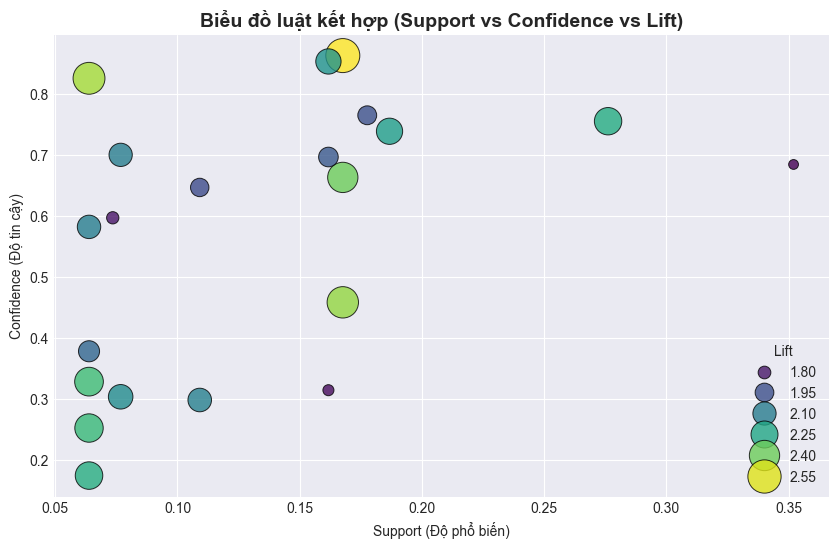

In [6]:
#  BIỂU ĐỒ 1: Bubble Chart (Support – Confidence – Lift)

plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')

sns.scatterplot(
    data=rules,
    x='support', y='confidence',
    size='lift', hue='lift', palette='viridis', alpha=0.8, edgecolor='black', sizes=(50, 600)
)

plt.title("Biểu đồ luật kết hợp (Support vs Confidence vs Lift)", fontsize=14, fontweight='bold')
plt.xlabel("Support (Độ phổ biến)")
plt.ylabel("Confidence (Độ tin cậy)")
plt.legend(title="Lift", loc='best')
plt.show()




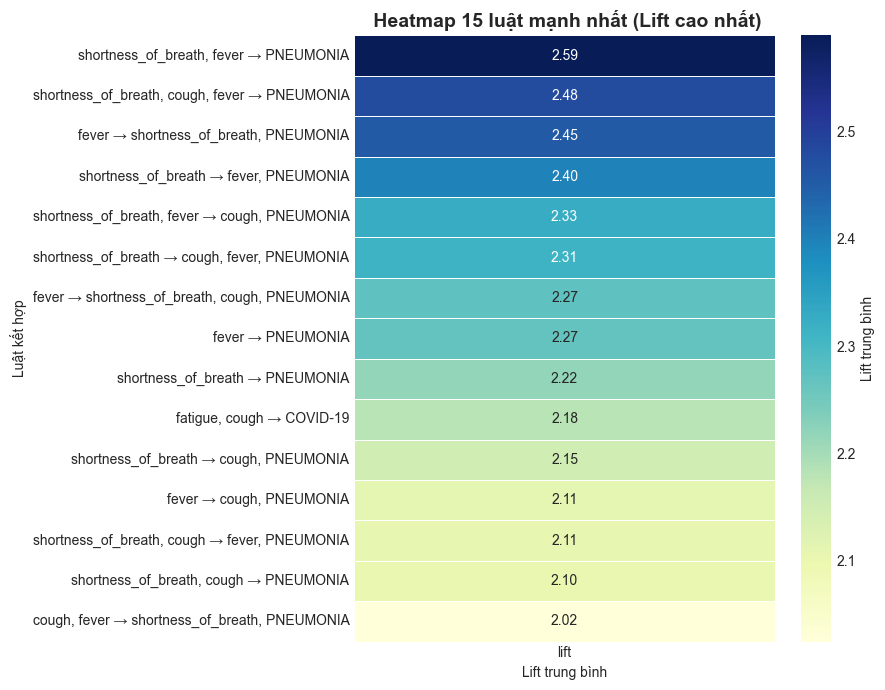

In [7]:
#  BIỂU ĐỒ 2: Heatmap TOP 15 luật mạnh nhất

top_rules = rules.head(15).copy()
top_rules['rule'] = top_rules.apply(
    lambda x: f"{', '.join(list(x['antecedents']))} → {', '.join(list(x['consequents']))}", axis=1
)

plt.figure(figsize=(9, 7))
sns.heatmap(
    top_rules.pivot_table(values='lift', index='rule', aggfunc='mean').sort_values('lift', ascending=False),
    annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5, cbar_kws={'label': 'Lift trung bình'}
)
plt.title(" Heatmap 15 luật mạnh nhất (Lift cao nhất)", fontsize=14, fontweight='bold')
plt.xlabel("Lift trung bình")
plt.ylabel("Luật kết hợp")
plt.tight_layout()
plt.show()




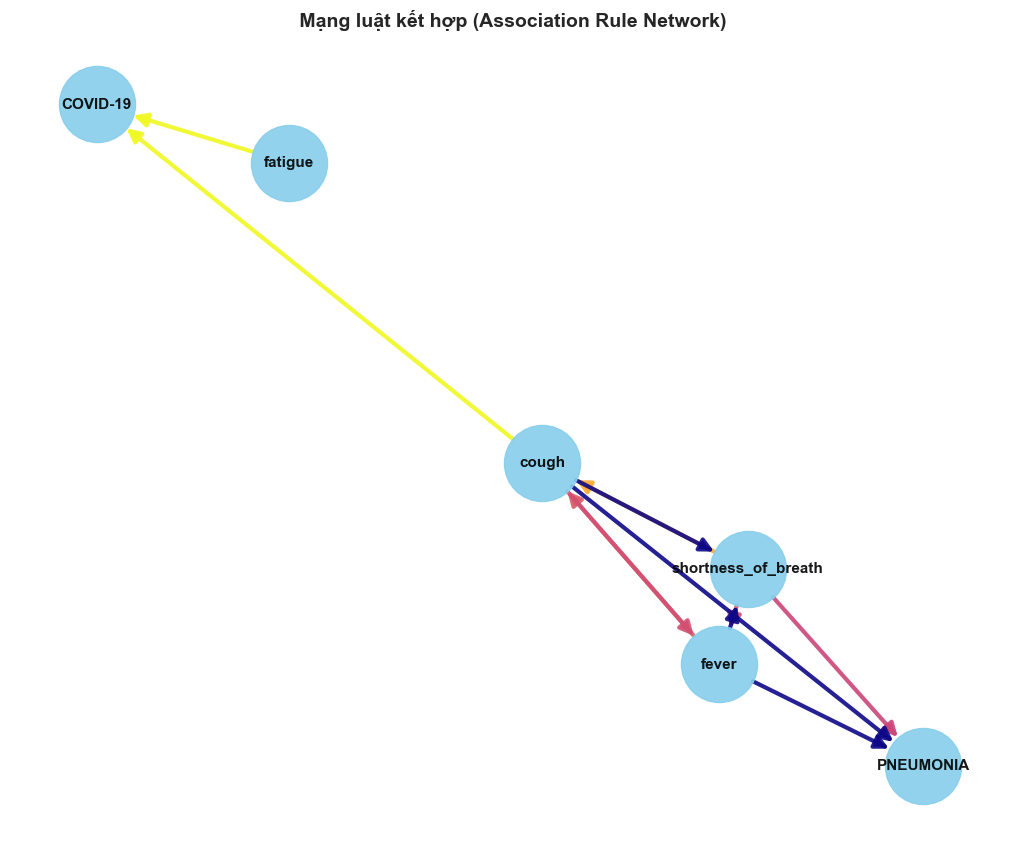


 Một vài luật nổi bật:
 Nếu bệnh nhân có [shortness_of_breath, fever] thì khả năng bị [PNEUMONIA] cao (Lift=2.59, Confidence=0.86)
 Nếu bệnh nhân có [shortness_of_breath, cough, fever] thì khả năng bị [PNEUMONIA] cao (Lift=2.48, Confidence=0.83)
 Nếu bệnh nhân có [fever] thì khả năng bị [shortness_of_breath, PNEUMONIA] cao (Lift=2.45, Confidence=0.46)
 Nếu bệnh nhân có [shortness_of_breath] thì khả năng bị [fever, PNEUMONIA] cao (Lift=2.40, Confidence=0.66)
 Nếu bệnh nhân có [shortness_of_breath, fever] thì khả năng bị [cough, PNEUMONIA] cao (Lift=2.33, Confidence=0.33)


In [8]:
#  BIỂU ĐỒ 3: Network Graph (Mạng luật kết hợp)

plt.figure(figsize=(10, 8))
G = nx.DiGraph()

# Chỉ lấy top 15 luật mạnh nhất để dễ nhìn
for _, row in top_rules.iterrows():
    ante = list(row['antecedents'])
    cons = list(row['consequents'])
    for a in ante:
        for c in cons:
            G.add_edge(a, c, weight=row['lift'])

# Vẽ đồ thị
pos = nx.spring_layout(G, k=0.7, seed=42)
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

nx.draw(
    G, pos, with_labels=True,
    node_color="skyblue", node_size=3000, font_size=11, font_weight='bold',
    edge_color=weights, edge_cmap=plt.cm.plasma, width=3,
    arrowsize=20, alpha=0.9
)

plt.title(" Mạng luật kết hợp (Association Rule Network)", fontsize=14, fontweight='bold')
plt.show()


#  GỢI Ý DIỄN GIẢI

print("\n Một vài luật nổi bật:")
for i, row in top_rules.head(5).iterrows():
    print(f" Nếu bệnh nhân có [{', '.join(list(row['antecedents']))}] thì khả năng bị [{', '.join(list(row['consequents']))}] cao (Lift={row['lift']:.2f}, Confidence={row['confidence']:.2f})")

# with open("frequent_itemsets.pkl", "wb") as f:
# pickle.dump(frequent_itemsets, f)





In [9]:
with open("../models/DM/rules_apriori.pkl", "wb") as f:
    pickle.dump(rules, f)